<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-balanced-data" data-toc-modified-id="Create-balanced-data-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Create balanced data</a></span></li></ul></li><li><span><a href="#Filter-Methods" data-toc-modified-id="Filter-Methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Filter Methods</a></span><ul class="toc-item"><li><span><a href="#Drop-Correlated-Features" data-toc-modified-id="Drop-Correlated-Features-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Drop Correlated Features</a></span></li><li><span><a href="#Univariate-with-roc-auc" data-toc-modified-id="Univariate-with-roc-auc-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Univariate with roc-auc</a></span></li></ul></li><li><span><a href="#Wrapper-Methods" data-toc-modified-id="Wrapper-Methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Wrapper Methods</a></span><ul class="toc-item"><li><span><a href="#Step-Forward-Feature-Selection" data-toc-modified-id="Step-Forward-Feature-Selection-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Step Forward Feature Selection</a></span></li><li><span><a href="#Step-Backward-Feature-Selection" data-toc-modified-id="Step-Backward-Feature-Selection-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Step Backward Feature Selection</a></span></li></ul></li><li><span><a href="#Embedding-Methods" data-toc-modified-id="Embedding-Methods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Embedding Methods</a></span><ul class="toc-item"><li><span><a href="#Random-Forest-Importance" data-toc-modified-id="Random-Forest-Importance-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Random Forest Importance</a></span></li><li><span><a href="#Recursive-Feature-Selection-using-RFs-importance" data-toc-modified-id="Recursive-Feature-Selection-using-RFs-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Recursive Feature Selection using RFs importance</a></span></li></ul></li></ul></div>

# Bank Markeint Feature Selection

We've seen the bank marketing dataset is an imbalanced data, and we found one of the useful balancing methods to apply to this dataset - `easyEnsemble`. 

After balancing the dataset, I would like to do feature selection. Feature selection provides a simple yet effective way to overcome high-dimensional data analysis by eliminating redundant and irrelevant data. Even though the dataset with 21 columns does not high space, we can still try to use feature selection methods, and explore the model's performance. 


In this notebook, I will go through three different feature selection methods: filter methods, wrapper methods, and embedding methods. 

### Import

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pathlib import Path
import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/BankMarketing'

In [2]:
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/BankMarketing')

In [12]:
# for the model 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier)

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import encoding as ce


# for cross-validation
from imblearn.pipeline import make_pipeline

# for ensemble sampling
from imblearn.ensemble import EasyEnsembleClassifier

# for feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Load data

In [23]:
data = pd.read_csv(path/'cleaned_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
print(data.shape)
data.head()

(41185, 21)


,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,pdays_group
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,51-60,Not contacted
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,51-60,Not contacted
2,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,31-40,Not contacted
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,31-40,Not contacted
4,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,51-60,Not contacted


In [9]:
cat_vars = [var for var in data.columns if var != 'y' and data[var].dtype == 'O']
num_vars = [var for var in data.columns if var != 'y' and data[var].dtype != 'O']

len(cat_vars), len(num_vars)

(12, 8)

In [43]:
def run_RFs(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=39)
    rf.fit(X_train, y_train)
    
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('RF roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('RF roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    
    return roc_auc_score(y_test, pred[:, 1])

### Create balanced data

As we saw the previous notebooks, the bank marketing dataset is imbalanced. Before I select features that I will use for building ML models, I will create balanced data by using easyEnsemble method. Also, I will use StandardScaler for feature scaling for numeric variables and integer encoding for categorical variables' encoding. 

In [11]:
# now we train several models, with the different oversamplers 
# and with cross-validation

# to save the results
roc_dict = {}

# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('y', axis=1),
    data['y'],
    test_size=0.3,
    random_state=0
)

# integer encoding
ordinal_encoding = ce.OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_vars)

ordinal_encoding.fit(X_train)
X_train = ordinal_encoding.transform(X_train)
X_test = ordinal_encoding.transform(X_test)


# StandardScaler
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)


# train model and store result
roc = run_RFs(X_train, X_test, y_train, y_test)
roc_dict['full_data'] = roc




Train set
RF roc-auc: 0.9277391477348833
Test set
RF roc-auc: 0.9301929165098902


In [15]:
# set up classifier
easy = EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        random_state=42,
    )

# set up the hyperparameter space
# the default implementation as 1 hyperparameters to optimize

param_grid = dict(
    n_estimators=stats.randint(10, 200),
    )


# set up the search
search = RandomizedSearchCV(
    easy, # the model
    param_grid, # hyperparam space
    scoring='roc_auc', # metric to optimize
    cv=5, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 10 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=10, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
# using the original data (without resampling)
search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=EasyEnsembleClassifier(n_estimators=20,
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb2d93ab940>},
                   random_state=10, scoring='roc_auc')

In [16]:
# the best hyperparameters are stored in an attribute:

search.best_params_

{'n_estimators': 74}

In [19]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

# save prediction
roc_dict['easyEnsemble'] = roc_auc_score(y_test, X_test_preds)

Train roc_auc:  0.9412903265888555
Test roc_auc:  0.9415625352829952


In [20]:
roc_dict

{'full_data': 0.9301929165098902, 'easyEnsemble': 0.9415625352829952}

In [24]:
copy = data.drop('y', axis=1)
X_columns = copy.columns

In [25]:
X_columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'age_group', 'pdays_group'],
      dtype='object')

In [27]:
X_train = pd.DataFrame(X_train, columns=X_columns)
X_test = pd.DataFrame(X_test, columns=X_columns)

## Filter Methods

Filter methods select features on the basis of the statistical scores for its correlation with the outcome variable. 

I will perform some methods as follows:

- Correlation
- LDA
- ANOVA
- Chi-Square

### Drop Correlated Features

In [29]:
# for feature selection
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection

In [36]:
# set up the selector

sel = DropCorrelatedFeatures(
    threshold=0.75,
    method='pearson',
    missing_values='ignore'
)

# find correlated features
sel.fit(X_train)

DropCorrelatedFeatures(threshold=0.75)

In [39]:
# 0.75
sel.correlated_feature_sets_

[{'poutcome', 'previous'},
 {'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed'}]

In [40]:
# drop correlated features
X_train_cor = sel.transform(X_train)
X_test_cor = sel.transform(X_test)

X_train_cor.shape, X_test_cor.shape

((28829, 16), (12356, 16))

In [41]:
X_train.shape

(28829, 20)

In [44]:
run_RFs(X_train_cor, X_test_cor, y_train, y_test)

Train set
RF roc-auc: 0.9247307730761275
Test set
RF roc-auc: 0.9256974828400699


0.9256974828400699

In [45]:
roc_dict['DropCorrelatedFeatures'] = run_RFs(X_train_cor, X_test_cor, y_train, y_test)

Train set
RF roc-auc: 0.9247307730761275
Test set
RF roc-auc: 0.9256974828400699


In [46]:
roc_dict

{'full_data': 0.9301929165098902,
 'easyEnsemble': 0.9415625352829952,
 'DropCorrelatedFeatures': 0.9256974828400699}

Compared to the baseline, the model performance did not improve with removal of correlated features. 

### Univariate with roc-auc 

This procedure works as follows:

- First, it builds one decision tree per feature, to predict the target
- Second, it makes predictions using the decision tree and the mentioned feature
- Third, it measures the performance of that prediciton, be it the roc-auc, the mse, or any other metric
- Fourth, it ranks the features according to the machine learning metric (roc-auc or mse)
- It selects the highest ranking features

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
# determine roc-auc for each feature

# copy X_train and X_test
X_train_uni = X_train.copy()
X_test_uni = X_test.copy()

# here we store the roc-auc values
roc_values = []

# iterate over each feature in the dataset
for feature in X_train_uni.columns:
    
    # train a decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train_uni[feature].fillna(0).to_frame(), y_train)
    
    # obtain the predictions
    y_scored = clf.predict_proba(X_test_uni[feature].to_frame())
    
    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [49]:
# display the result
roc_values

[0.614766510194158,
 0.5405249739484247,
 0.5656379059742389,
 0.560785510855462,
 0.5096258951469372,
 0.50451334784624,
 0.6169237141653673,
 0.6664598163208592,
 0.5341609131972878,
 0.7508824219226156,
 0.5619870827550338,
 0.6203144843586103,
 0.6251560053739884,
 0.7735932678128391,
 0.7956298862403525,
 0.7956298862403525,
 0.7908611456981783,
 0.7857912685114258,
 0.6011649569094648,
 0.6044743200611541]

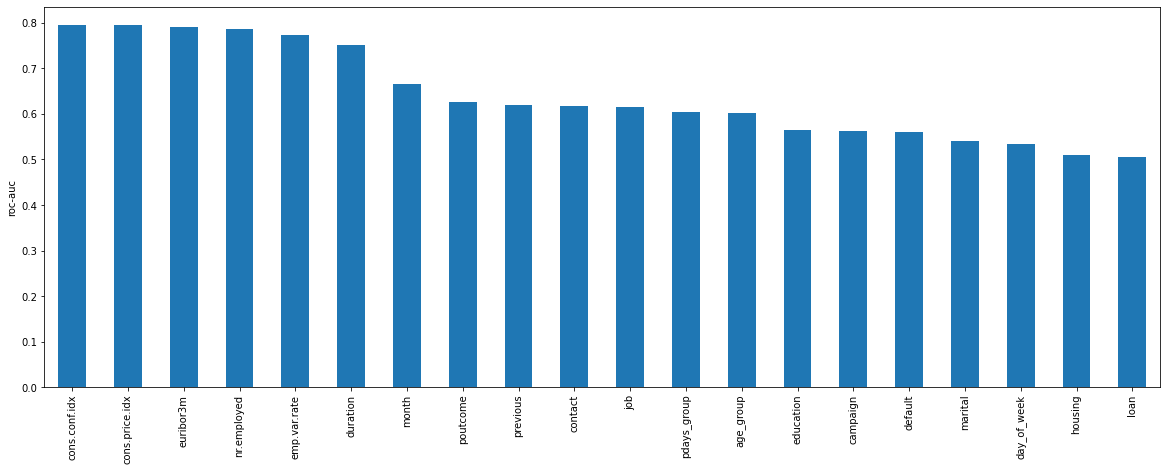

In [51]:
# now let's 

# 1) capture the roc-auc values in a pandas series
# 2) add the variable names in the index
# 3) sort the features based on the roc-auc
# 4) and make a var plot

roc_values = pd.Series(roc_values)
roc_values.index = X_train_uni.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(18,7))
plt.ylabel('roc-auc');

In [59]:
len(roc_values[roc_values>0.55])

16

In [60]:
selected_features = roc_values[roc_values > 0.55].index
selected_features

Index(['job', 'education', 'default', 'contact', 'month', 'duration',
       'campaign', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'age_group',
       'pdays_group'],
      dtype='object')

In [62]:
run_RFs(X_train, X_test, y_train, y_test)

Train set
RF roc-auc: 0.9277391477348833
Test set
RF roc-auc: 0.9301929165098902


0.9301929165098902

In [61]:
X_train_uni = X_train_uni[selected_features]
X_test_uni = X_test_uni[selected_features]

run_RFs(X_train_uni, X_test_uni, y_train, y_test)

Train set
RF roc-auc: 0.9193107572943642
Test set
RF roc-auc: 0.9228528306117448


0.9228528306117448

Removing some features which are below 0.55 roc-auc-scores did not improve the model performance. 

## Wrapper Methods

### Step Forward Feature Selection

Step forward feature selection starts by training a machine learning model for each feature in the dataset and selects the one that returns the best performing model, accoridng to a certain evaludation criteria we choose. 

In the second step, it creates machine learning models for all combinations of the feature selected in the previous step and a second feature. It selects the pair that produces the best performing algorithm. 

It continues by adding 1 feature at a time to the features that were pre-selected in previous steps, until a pre-determined stopping criteria. 

In [63]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [65]:
# copy train and test set
X_train_forward = X_train.copy()
X_test_forward = X_test.copy()


# within the SFS we indicate:

# 1) the algorithm we sant to create, in this case RFs

# 2) the stopping criteria: want to select 15 features

# 3) whether to perform step forward or step backward

# 4) the evaluation metric: in this case the roc-auc
# 5) the cross-validation

sfs = SFS(RandomForestClassifier(n_estimators=10, n_jobs=1, random_state=0), 
         k_features=20, 
         forward=True, 
         floating=False, 
         verbose=2,
         scoring='roc_auc',
         cv=3)

sfs = sfs.fit(np.array(X_train_forward), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.5s finished

[2022-01-17 12:37:18] Features: 1/20 -- score: 0.778366205122459[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.9s finished

[2022-01-17 12:37:23] Features: 2/20 -- score: 0.8421274471230964[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.8s finished

[2022-01-17 12:37:30] Features: 3/20 -- score: 0.8739675518072683[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

It seems like we need to use all features, because the model performance did not improve by removing some features. 

### Step Backward Feature Selection

Step Backward feature selection starts by fitting a model using all features in the data set and determining its performance. 

Then, it trains models on all possible combinations of all features -1, and removes the feature that returns the model with the lowest performance. 

In the third step it trains models in all possible combinations of the features remaining from step 2 -1 feature, and removes the feature that produced the lowest performing model. 

The algorithm stops on a criteria determined by the user. This criteria could be that the model performance does not decrease beyond a certain threshold, or alternatively, as in the mlxtend implementation, when we reach a certain number of selected features. 

In [66]:
# copy train and test set
X_train_backward = X_train.copy()
X_test_backward = X_test.copy()


# within the SFS we indicate:

# 1) the algorithm we sant to create, in this case RFs

# 2) the stopping criteria: want to select 15 features

# 3) whether to perform step forward or step backward

# 4) the evaluation metric: in this case the roc-auc
# 5) the cross-validation

sfs = SFS(RandomForestClassifier(n_estimators=10, n_jobs=1, random_state=0), 
         k_features=2, 
         forward=False, 
         floating=False, 
         verbose=2,
         scoring='roc_auc',
         cv=3)

sfs = sfs.fit(np.array(X_train_backward), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.8s finished

[2022-01-17 12:43:01] Features: 19/2 -- score: 0.9145501363623172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    9.6s finished

[2022-01-17 12:43:11] Features: 18/2 -- score: 0.9158213600799202[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    9.2s finished

[2022-01-17 12:43:20] Features: 17/2 -- score: 0.9151258801606653[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

## Embedding Methods

### Random Forest Importance

Random Forests is one of the most popular machine learning algorithms. It is so successful because it provide good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision. 

Random forests consist typically of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or a combination of features. At each node, the three divides the dataset in 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is.

For classification, the measure of impurity is either Gini or the entropy. For regression, the measure of impurity is the variance. When training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease elicited by each feature is averaged across trees to determine the final importance of the variable. 

In general, features that are selected at the top of the trees are more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains. 


__Note__
- Random Forests and decision trees in general give preference to features with high cardinality. 
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts. 


Selecting features by using tree derived feature importance is a very straightforward, fast and generally accurate way of selecting good features for machine learning. In particular, if you are going to build tree methods. 

In [73]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [69]:
# copy train and test set
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

# here I will do the model fitting and feature selection altogeter
# 1) specify the Random Forest model
# 2) select Lasso penalty
# 3) use selectFromModel from sklearn, which will select the features 
# which coefficients are non-zero

sel_ = SelectFromModel(
    RandomForestClassifier(n_estimators=10, random_state=10))

sel_.fit(X_train_rf, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=10))

In [70]:
sel_.get_support()

array([ True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True,  True,
       False, False])

In [71]:
# let's make a list and count the selected features
selected_feat = X_train_rf.columns[(sel_.get_support())]
len(selected_feat)

4

In [72]:
selected_feat

Index(['job', 'duration', 'euribor3m', 'nr.employed'], dtype='object')

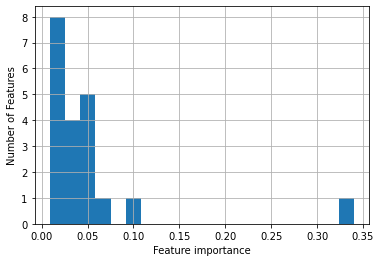

In [74]:
# let's plot the distribution of importances
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [75]:
X_train_rf = X_train_rf[selected_feat]
X_test_rf = X_test_rf[selected_feat]

run_RFs(X_train_rf, X_test_rf, y_train, y_test)

Train set
RF roc-auc: 0.9252639401098965
Test set
RF roc-auc: 0.9263813614826965


0.9263813614826965

In [76]:
run_RFs(X_train, X_test, y_train, y_test)

Train set
RF roc-auc: 0.9277391477348833
Test set
RF roc-auc: 0.9301929165098902


0.9301929165098902

Interestingly, the model performance with 4 features is similar to all features (20)

### Recursive Feature Selection using RFs importance

Random forests assign equal or similar importance to features that are highly correlated. In addition, when features are correlated, the importance assigned is lower than the importance attributed to the feature itself, should the tree be built without the correlated counterparts. 

Therefore, instead of eliminating features based on importance by brute force like we did, we could get a better selection by removing one feature at a time, and recalculating the importance on each round. this procedure is called __Recursive Feature Elimination (RFE)__

RFE is a hybrid between embedded and wrapper methods: it is based on computation dericed when fitting the model, but it also requires fitting several models.

The cycle is as follows:

- Build Random Forests using all features
- Remove least important feature
- Build Random Forests and recalculate importance
- Repeat until a criteria is met

In this situation, when a feature that is highly correlated to another one is removed, then the importance of the remaining feature increases. This may lead to a better feature space selection. On the downside, building several RF is quite time and compute resource consuming, in particular if the dataset contains a high number of features. 

In [77]:
from sklearn.feature_selection import RFE

In [78]:
# copy train and test set
X_train_rfe = X_train.copy()
X_test_rfe = X_test.copy()

sel_ = RFE(RandomForestClassifier(n_estimators=10, random_state=10), 
           n_features_to_select=15)
sel_.fit(X_train_rfe, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=15)

In [79]:
# selected features
selected_feat = X_train_rfe.columns[(sel_.get_support())]
len(selected_feat)

15

In [80]:
selected_feat

Index(['job', 'marital', 'education', 'housing', 'month', 'day_of_week',
       'duration', 'campaign', 'poutcome', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'age_group', 'pdays_group'],
      dtype='object')

In [81]:
X_train_rfe = X_train_rfe[selected_feat]
X_test_rfe = X_test_rfe[selected_feat]
run_RFs(X_train_rfe, X_test_rfe, y_train, y_test)

Train set
RF roc-auc: 0.9269670366189108
Test set
RF roc-auc: 0.9296192992926082


0.9296192992926082

This one is slightly better than when we used 4 features

In [84]:
# copy train and test set
X_train_rfe = X_train.copy()
X_test_rfe = X_test.copy()

sel_ = RFE(RandomForestClassifier(n_estimators=10, random_state=10), 
           n_features_to_select=16)
sel_.fit(X_train_rfe, y_train)

selected_feat = X_train_rfe.columns[(sel_.get_support())]
print(len(selected_feat))
print(selected_feat)

X_train_rfe = X_train_rfe[selected_feat]
X_test_rfe = X_test_rfe[selected_feat]
run_RFs(X_train_rfe, X_test_rfe, y_train, y_test)

16
Index(['job', 'marital', 'education', 'housing', 'loan', 'month',
       'day_of_week', 'duration', 'campaign', 'poutcome', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'age_group',
       'pdays_group'],
      dtype='object')
Train set
RF roc-auc: 0.9286474530797659
Test set
RF roc-auc: 0.9318357985267276


0.9318357985267276

In [90]:
# copy train and test set
X_train_rfe = X_train.copy()
X_test_rfe = X_test.copy()

sel_ = RFE(RandomForestClassifier(n_estimators=10, random_state=10), 
           n_features_to_select=20)
sel_.fit(X_train_rfe, y_train)

selected_feat = X_train_rfe.columns[(sel_.get_support())]
print(len(selected_feat))
print(selected_feat)

X_train_rfe = X_train_rfe[selected_feat]
X_test_rfe = X_test_rfe[selected_feat]
run_RFs(X_train_rfe, X_test_rfe, y_train, y_test)

20
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'age_group', 'pdays_group'],
      dtype='object')
Train set
RF roc-auc: 0.9277391477348833
Test set
RF roc-auc: 0.9301929165098902


0.9301929165098902

As we can see above, when we use 16 features to build a model, it shows the best score. 